# Frequency Modulation 

 
 

In [1]:
# General useful imports
import array as ar
import contextlib
import wave
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

from numpy import arange,linspace,mean, var, std, corrcoef, cov, transpose, ones,log,pi, sin, cos, exp, abs, angle, convolve
from numpy.random import random, randint, uniform
from scipy import signal
from scipy.interpolate import interp1d

%matplotlib inline

# Basic parameters for reading and writing mono wave files

numChannels   = 1                      # mono
sampleWidth   = 2                      # in bytes, a 16-bit short
SR            = 44100                  #  sample rate
MAX_AMP       = (2**(8*sampleWidth - 1) - 1)    #maximum amplitude is 2**15 - 1  = 32767
MIN_AMP       = -(2**(8*sampleWidth - 1))       #min amp is -2**15
windowWidth   = 4410
windowSlide   = 2205


def round4(x):
    return np.around(x,4)

def round2(x):
    return np.around(x,2)

# Basic Numpy statistical functions

X = np.array([1,2,3])       # just an example
Y = np.array([4,5,6])
             
# mean of a list
mean(X)                            

# Clip a signal or a scalar to upper and lower bounds, if not specified, us
# bounds provided above; will change the array in place and return it.
# Does NOT make a new copy. 

def clip(X,lb=MIN_AMP,ub=MAX_AMP):
    
    if type(X) != list and type(X) != np.ndarray:
        return max(min(X,MAX_AMP),MIN_AMP)
    
    for k in range(len(X)):
        X[k] = max(min(X[k],MAX_AMP),MIN_AMP)
    return X

# To prevent clipping, this function takes a signal and scales it so the max amplitude
# is A; the result is coerced back into integers

def scaleSignal(X,A=MAX_AMP):
    s = A/max(X)
    return np.array( [ x*s for x in X ] ).astype(int)

# default is not to standardize the amplitude, if want scaled down or up set
# relative amp

def makeSignal(S=[(220,1,0)], amp=None, duration=1):
    X = np.zeros(int(SR*duration))  
    for (f,A,phi) in S:         
        X += [ (MAX_AMP * A) * np.sin( 2 * pi * f * k / SR + phi ) for k in range(len(X)) ]
    if amp == None:
        return X.astype(int) 
    else:
        return ((X / max(X)) * MAX_AMP * amp).astype(int) 
    
    
# some useful spectra    

def makeSpectrum(instr,freq=220):
    if(instr=="triangle"):
        return ([(freq,1.0,0.0),    
        (freq*3,-1/(9),0.0), 
        (freq*5,1/(25),0.0), 
        (freq*7,-1/(49),0.0), 
        (freq*9,1/(81),0.0), 
        (freq*11,-1/(121),0.0), 
        (freq*13,1/(13*13),0.0)])
    elif(instr=="square"):
        return ([(freq,2/(np.pi),0.0), 
        (freq*3,2/(3*np.pi),0.0), 
        (freq*5,2/(5*np.pi),0.0), 
        (freq*7,2/(7*np.pi),0.0), 
        (freq*9,2/(9*np.pi),0.0), 
        (freq*11,2/(11*np.pi),0.0), 
        (freq*13,2/(13*np.pi),0.0),
        (freq*15,2/(15*np.pi),0.0),
        (freq*17,2/(17*np.pi),0.0),
        (freq*19,2/(19*np.pi),0.0),
        (freq*21,2/(21*np.pi),0.0)])
    elif(instr=="clarinet"):
        return ([(freq,0.314,0.0), 
        (freq*3,.236,0.0), 
        (freq*5,0.157,0.0), 
        (freq*7,0.044,0.0), 
        (freq*9,0.157,0.0), 
        (freq*11,0.038,0.0), 
        (freq*13,0.053,0.0)] ) 
    elif(instr=="bell"):
        return ([(freq,0.1666,0.0), 
        (freq*2,0.1666,0.0), 
        (freq*3,0.1666,0.0), 
        (freq*4.2,0.1666,0.0), 
        (freq*5.4,0.1666,0.0), 
        (freq*6.8,0.1666,0.0)])  
    elif(instr=="steelstring"):
        return ([(freq*0.7272, .00278,0.0),
        (freq, .0598,0.0),
        (freq*2, .2554,0.0),
        (freq*3, .0685,0.0),
        (freq*4, .0029,0.0),
        (freq*5, .0126,0.0),
        (freq*6, .0154,0.0),
        (freq*7, .0066,0.0),
        (freq*8, .0033,0.0),
        (freq*11.0455, .0029,0.0),
        (freq*12.0455, .0094,0.0),
        (freq*13.0455, .0010,0.0),
        (freq*14.0455, .0106,0.0),
        (freq*15.0455, .0038,0.0)])
    elif(instr=='organ'):
        return ([(freq*1, 0.16042589643241895, 0.0),
        (freq*2, 0.1655, 0.0),
        (freq*3, 0.0015, 0.0),
        (freq*3.9949, 0.02161, 0.0),
        (freq*5.9949, 0.04552, 0.0),
        (freq*7.9949, 0.0324, 0.0),
        (freq*9.9899, 0.00242, 0.0),
        (freq*11.9898, 0.0045, 0.0),
        (freq*17.9847, 0.0057, 0.0),
        (freq*19.9796, 0.0011, 0.0),
        (freq*27.9745, 0.0008, 0.0),
        (freq*29.9745, 0.0016, 0.0)]        
        )
    else:
        return []


In [2]:
# I/O for Wave files

# Read a mono wave file from a local file and return the entire file as a 1-D numpy array

def readWaveFile(infile,withParams=False,asNumpy=True):
    with contextlib.closing(wave.open(infile)) as f:
        params = f.getparams()
        frames = f.readframes(params[3])
        if(params[0] != 1):
            print("Warning in reading file: must be a mono file!")
        if(params[1] != 2):
            print("Warning in reading file: must be 16-bit sample type!")
        if(params[2] != 44100):
            print("Warning in reading file: must be 44100 sample rate!")
    if asNumpy:
        X = ar.array('h', frames)
        X = np.array(X,dtype='int16')
    else:  
        X = array.array('h', frames)
    if withParams:
        return X,params
    else:
        return X

# Write out an array as a wave file to the local directory
        
def writeWaveFile(X,fname):
    X = clip(X)
    params = [1,2, SR , len(X), "NONE", None]
    data = ar.array("h",X)
    with contextlib.closing(wave.open(fname, "w")) as f:
        f.setparams(params)
        f.writeframes(data.tobytes())
    print(fname + " written.")

In [3]:
# Display a graph of a signal

def displaySignal(X, left = 0, right = -1, minAmp=-1.2, maxAmp=1.2,title='Signal Window for X',signalRelative=False,xUnits = "Seconds", yUnits = "Relative",width=12, height=4):
    
    if(signalRelative):
        X = [x*MAX_AMP for x in X]
    minAmplitude = -(2**15 + 100)        # just to improve visibility of curve
    maxAmplitude = 2**15 + 300    
    
    if(xUnits == "Samples"):
        if(right == -1):
            right = len(X)
        T = range(left,right)
        Y = X[left:right]
    elif(xUnits == "Seconds"):
        if(right == -1):
            right = len(X)/44100
        T = np.arange(left, right, 1/44100)
        leftSampleNum = int(left*44100)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    elif(xUnits == "Milliseconds"):
        if(right == -1):
            right = len(X)/44.1
        T = np.arange(left, right, 1/44.1)
        leftSampleNum = int(left*44.1)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    else:
        print("Illegal value for xUnits")
        
    if(yUnits == "Relative"):
        minAmplitude = minAmp            # just to improve visibility of curve
        maxAmplitude = maxAmp
        Y = [x/32767 for x in Y]

    fig = plt.figure(figsize=(width,height))   # Set x and y dimensions of window: may need to redo for your display
    fig.suptitle(title, fontsize=14, fontweight='bold')
    ax = plt.axes()
    if(xUnits=="Samples"):
        ax.set_xlabel("Sample Number")
    else:
        ax.set_xlabel(xUnits)
    ax.set_ylabel(yUnits + ' Amplitude')
    ax.set_ylim([minAmplitude,maxAmplitude])
    ax.set_xlim([left, right])
    plt.axhline(0, color='black')      # draw the 0 line in black
    plt.plot(T,Y) 
    if(    (xUnits == "Samples" and (right - left) < 101)
        or (xUnits == "Seconds" and (right - left) < 0.001)
        or (xUnits == "Milliseconds" and (right - left) < 1) ):
            plt.plot(T,Y, 'ro')                     
    plt.grid(True)                     # if you want dotted grid lines
    plt.show()
    
f = 10
T = np.arange(SR*1)
X = MAX_AMP * np.sin(2*pi*f*T/SR)

# displaySignal(X)

In [4]:
# This will display a list of signals in aligned subplots, with separate titles

def plotSignals(signals, titles=[]):
    print()
    if titles == []:
        if len(signals) > 1:
            titles = ['Signal ' + str(k+1) + '\n' for k in range(len(signals))]
        else:
            titles = ['Signal\n']
    else:
        titles = [t + '\n' for t in titles]
            
    number_of_subplots=len(signals)
    
    N = len(signals[0])

    fig = plt.figure(figsize=(12,number_of_subplots*4))
    fig.subplots_adjust(hspace=0.75)
    #fig.suptitle("Comparison ",fontsize=16)
    
    for i,v in enumerate(range(number_of_subplots)):
        v = v+1
        ax1 = subplot(number_of_subplots,1,v)
        
        ax1.set_ylabel('Amplitude')
        ax1.set_xlabel('Time (ms)') 
        ax1.plot([0,N-1],[0,0],color='black',lw=0.75)
        ax1.plot([0,0],[-1,1],color='black',lw=0.75)    
        ax1.set_ylim([-1.2,1.2])
        plt.xlim([0,N-1])
        ax1.grid(color='0.75')
        ax1.plot(signals[i],color='b',lw=1)
        ax1.set_title(titles[i],fontsize=14)
    plt.show()

# Just an example
  
f = 10
T = np.arange(SR*1)
X10 = np.sin(2*pi*f*T/SR)
X20 = np.sin(2*pi*2*f*T/SR)
X30 = np.sin(2*pi*3*f*T/SR)
X40 = np.sin(2*pi*4*f*T/SR)

# plotSignals([X10,X20,X30,X40])

##  Frequency Modulation

As discussed in lecture, frequency modulation changes the frequency of the carrier signal, as if it is a vibrato on steroids:  the vibrato frequency can be anything, even larger than the original carrier frequency!

In a simple implementation, the carrier signal has frequency $fc$ and relative amplitude $Ac$, and
the modulator (the vibrato) has frequency $fm$ and $Am$. 

The only difficulty is that when changing the frequency, we have to ensure that the new sine wave will start
at the same phase as the current signal, hence we calculate the instantaneous phase each time. 

In [5]:
def FM(fc,Ac,fm,Am,duration):
    X = np.zeros(SR * duration)
    phase = 0.0
    newFreq = f1
    for k in range( SR*duration ):
        freqIncr = Am * np.sin(2*np.pi*fm*k/SR)  # modulating signal
        oldFreq = newFreq
        newFreq = fc + freqIncr
        phase +=  2 * pi * (k / SR) * (oldFreq - newFreq)      
        X[k] = Ac*MAX_AMP*np.sin(2*np.pi*newFreq*k/SR + phase)
    return X
    

In order to control and analyze FM, it is useful to consider the *modulation index*, which in this case
means the ratio of the total deviation of the carrier frequency to the modulating frequency:

$$\text{index}\ =\ {\text{Total deviation of carrier frequency}\over \text{Modulator frequency}}\ 
=\ { 2*A2  \over  f2  }.    $$

The modulation index can then be used to calculate the amplitudes (we'll assume A1 = 1.0):

In [6]:
def FM_index(f1,f2,index, duration):
    X = np.zeros(int(SR * duration))
    phase = 0.0
    newFreq = f1
    for k in range( int(SR*duration) ):
        A2 = f2*index 
        freqIncr = A2 * np.sin(2*np.pi*f2*k/SR)  # modulating signal
        oldFreq = newFreq
        newFreq = f1 + freqIncr
        phase +=  2 * pi * (k / SR) * (oldFreq - newFreq)      
        X[k] = MAX_AMP*np.sin(2*np.pi*newFreq*k/SR + phase)
    return X

fc = 500
fm = 1
index = 500
duration = 6
X = FM_index(fc,fm,index,duration)
Audio(X,rate=SR)

A common technique to simulate changing spectra (such as exhibited by percussion instruments) is
to gradually reduce the index to 0 during the signal. As John Chowning says in his original paper on
FM:
<blockquote>
 As demonstrated above, the equation for FM has an inherent
and, as will be shown, most useful characteristic: the complexity
of the spectrum is related to the modulation index in such a way
that as the index increases, the bandwidth of the spectrum also
increases (see Fig. 5). If, then, the modulation index were made
to be a function of time, the evolution of the bandwidth of the
spectrum could be generally described by the shape of the
function. <a href="https://ccrma.stanford.edu/sites/default/files/user/jc/fm_synthesispaper-2.pdf">Chowning</a>. 
</blockquote>

We will simply assume that the index changes in a linear slope between an initial value and a final value:

In [7]:
def FM_mod_index(f1,f2,init_index, final_index, duration):
    N = int(SR * duration)
    X = np.zeros( N )
    phase = 0.0
    newFreq = f1
    Index = np.linspace(init_index,final_index,N)
    for k in range( N ):
        A2 = (f2*Index[k])
        freqIncr = A2 * np.sin(2*np.pi*f2*k/SR)  # modulating signal
        oldFreq = newFreq
        newFreq = f1 + freqIncr
        phase +=  2 * pi * (k / SR) * (oldFreq - newFreq)      
        X[k] = MAX_AMP*np.sin(2*np.pi*newFreq*k/SR + phase)
    return X

fc = 220
fm = 220
index = 10
duration = 3
X = FM_mod_index(fc,fm,index,0,duration)
Audio(X,rate=SR)

These examples are from http://sites.music.columbia.edu/cmc/MusicAndComputers/chapter4/04_07.php

In [8]:
# Bell sound

fc = 100
fm = 280
index = 6
duration = 5
X = FM_mod_index(fc,fm,index,0,duration)
Audio(X,rate=SR)

In [9]:
# Bass-Clarinet or a gong?

fc = 250
fm = 175
index = 2
duration = 3
X = FM_mod_index(fc,fm,index,0,duration)
Audio(X,rate=SR)

In [10]:
# trumpet 

fc = 700
fm = 700
index = 5
duration = 0.5
X = FM_mod_index(fc,fm,index,0,duration)
Audio(X,rate=SR)

In [11]:
# woodwinds

fc = 900
fm = 300
index = 2
duration = 1
X = FM_mod_index(fc,fm,index,0,duration)
Audio(X,rate=SR)

In [12]:
# FM sound

fc = 500
fm = 100
index = 1.5
duration = 1
X = FM_mod_index(fc,fm,index,0,duration)
Audio(X,rate=SR)

In [13]:
fc = 200
fm = 280
index = 10
duration = 8
X = FM_mod_index(fc,fm,index,0,duration)
Audio(X,rate=SR)

In [14]:
fc = 200
fm = 280
duration = 5
X = FM_mod_index(fc,fm,1,10,duration)
Audio(X,rate=SR)

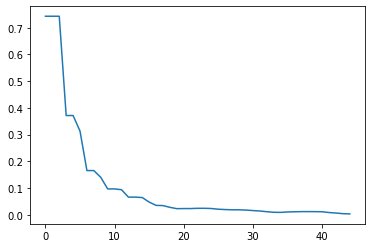

In [15]:
def resample(X,M):
    N = len(X)
    T = np.arange(N)
    f = interp1d(np.arange(N),X,kind='quadratic')
    T1 = np.linspace(0,N-1,M)
    return [ f(t) for t in T1]


def getAmplitudePlot(X, window_size=4410, overlap=0.5):
    N = len(X)
    lo = 0
    hi = window_size
    skip = int((1-overlap)*window_size)
    
    A = []
    while lo < N:
        A.append(max(X[lo:hi]))
        lo += skip
        hi += skip
    return np.array(A) / SR



def FM_env_index(f1,f2,index, index_envelope, duration):
    N = int(SR * duration)
    X = np.zeros( N )
    phase = 0.0
    newFreq = f1
    Index = resample(index * index_envelope, N)
#     print((index * index_envelope)[:20])
#     print(Index[:20])
    for k in range( N ):
        A2 = (f2*Index[k])
        freqIncr = A2 * np.sin(2*np.pi*f2*k/SR)  # modulating signal
        oldFreq = newFreq
        newFreq = f1 + freqIncr
        phase +=  2 * pi * (k / SR) * (oldFreq - newFreq)      
        X[k] = MAX_AMP*np.sin(2*np.pi*newFreq*k/SR + phase)
    return X

A = getAmplitudePlot( readWaveFile('bell.wav') )
plt.plot(A)
plt.show()

# Bell sound

# fc = 100
# fm = 280
# index = 6
# duration = 5
# X = FM_decreasing_index(fc,fm,index,duration)
# Audio(X,rate=SR)

fc = 2000
fm = 2800
index = 10
duration = 5
X = FM_env_index(fc,fm,index,A,duration)
Audio(X,rate=SR)

In [16]:
# tremolo envelope

def makeTremoloEnvelope(f, d,duration=1.0):
    return np.array([ (d/2) * np.sin( 2 * pi * f * k / SR ) + (1.0 - d/2) for k in range(int(duration*SR)) ])

# half_life is in seconds, so leave duration at 1.0 and half_life is percentage of envelope

def makeExpDecayEnvelope(half_life,duration=1.0):
    return np.array( [ 2.0**(-t/(half_life*SR)) for t in range(int(duration*SR)) ] )


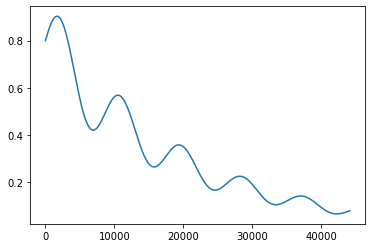

In [17]:
E1 = makeTremoloEnvelope(5,0.4)
E2 = makeExpDecayEnvelope(0.3)
E = E1 * E2
plt.plot(E)
plt.show()

fc = 100
fm = 280
index = 6
duration = 10
X = FM_env_index(fc,fm,index,E,duration)

Audio(X,rate=SR)

In [18]:
fc = 220
fm = 220
index = 10
duration = 3
X = FM_env_index(fc,fm,index,E,duration)
Audio(X,rate=SR)